In [1]:
#Python version
!python --version

Python 3.6.13 :: Anaconda, Inc.


In [2]:
#Install uninstalled modules, comment if it's already installed

#!pip install tensorflow==1.15 finta stable-baselines MetaTrader5 gym gym-anytrading quantstats

In [3]:
#Import needed modules
import gym
import gym_anytrading
from gym_anytrading.envs import ForexEnv

import numpy as np
import quantstats as qs

from stable_baselines.a2c import A2C
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpLstmPolicy
from stable_baselines.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

import matplotlib.pyplot as plt
import pandas as pd
from finta import TA

import datetime, os, pytz
import MetaTrader5 as mt5

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

C:\Users\dhupee\anaconda3\envs\DeepL_3.6\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.

In [4]:
#Trading Account Parameter
account = 647545 #Account number
password = "QpjpAGkK" #Password number
server = "FBS-Demo" #Server name
mt5_path = "C:\Program Files\FBS MetaTrader 5\terminal64.exe" #path of Metatrader5 director

mt5.initialize(
   path = mt5_path,          # path to the MetaTrader 5 terminal EXE file
   login = account,          # account number
   password = password,      # password
   server = server,          # server name as it is specified in the terminal
   #timeout = TIMEOUT,       # timeout
   portable = False          # portable mode
   )

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__,"\n")

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize failed, error code =",mt5.last_error())
    mt5.shutdown()
else:
    print("MetaTrader5 Initialized!")

# extract account information and turn it into dataframe   
authorized=mt5.login(account, password, server)
if authorized:
    # display trading account data 'as is'
    print("Metatrader5 authorized!")
    account_info_dict = mt5.account_info()._asdict()
    Acc_Info = pd.DataFrame(list(account_info_dict.items()),columns=['property','value'])
    print("\n", "account_info() as dataframe:")
    print(Acc_Info)
else:
    print("Metatrader5 cant authorize, error code: {}".format(mt5.last_error()))

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34 

MetaTrader5 Initialized!
Metatrader5 authorized!

 account_info() as dataframe:
              property             value
0                login            647545
1           trade_mode                 0
2             leverage              1000
3         limit_orders               100
4       margin_so_mode                 0
5        trade_allowed              True
6         trade_expert              True
7          margin_mode                 2
8      currency_digits                 2
9           fifo_close             False
10             balance            100000
11              credit                 0
12              profit                 0
13              equity            100000
14              margin                 0
15         margin_free            100000
16        margin_level                 0
17      margin_so_call                40
18        margin_so_so                20
19    

In [5]:
#Extract Account info from dataframe
leverage = Acc_Info.loc[2, "value"]
equity = Acc_Info.loc[13, "value"]
margin_free = Acc_Info.loc[15, "value"]

print(leverage)
print(equity)
print(margin_free)

1000
100000.0
100000.0


In [6]:
# extract information from pair and timeframe
Symbol = "EURUSD"
Timeframe = mt5.TIMEFRAME_D1
symbol_info = mt5.symbol_info(Symbol)
if symbol_info!=None:
    # display the terminal data 'as is'    
    print(symbol_info)
    print("\n","{}: spread =".format(Symbol),symbol_info.spread,"  digits =",symbol_info.digits, "\n")
    # Extract symbol info
    
    print(symbol_info[3])

SymbolInfo(custom=False, chart_mode=0, select=True, visible=True, session_deals=0, session_buy_orders=0, session_sell_orders=0, volume=0, volumehigh=0, volumelow=0, time=1623455995, digits=5, spread=33, spread_float=True, ticks_bookdepth=0, trade_calc_mode=0, trade_mode=4, start_time=0, expiration_time=0, trade_stops_level=1, trade_freeze_level=0, trade_exemode=2, swap_mode=1, swap_rollover3days=3, margin_hedged_use_leg=False, expiration_mode=15, filling_mode=3, order_mode=127, order_gtc_mode=0, ...)

 EURUSD: spread = 33   digits = 5 

True


In [7]:
# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")

# getbars from the current day
bar = 2000
rates = mt5.copy_rates_from_pos(Symbol, Timeframe, 0, bar)
 
# create DataFrame out of the obtained data
rates_frame = pd.DataFrame(rates, dtype=np.dtype("float"))
# convert time in seconds into the datetime format
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
                           
# display data
print("\nDisplay dataframe with data")
print(rates_frame)

# turn rates frame into csv file
rates_frame.to_csv('./Datasets/{}.csv'.format(Symbol), index=False)
pd.read_csv('./Datasets/{}.csv'.format(Symbol))


Display dataframe with data
           time     open     high      low    close  tick_volume  spread  \
0    2013-10-03  1.35812  1.36455  1.35774  1.36215      38034.0     1.0   
1    2013-10-04  1.36219  1.36315  1.35384  1.35565      34243.0     1.0   
2    2013-10-07  1.35629  1.35909  1.35425  1.35766      31485.0     1.0   
3    2013-10-08  1.35767  1.36070  1.35573  1.35727      31661.0     1.0   
4    2013-10-09  1.35729  1.36044  1.34857  1.35232      39161.0     1.0   
...         ...      ...      ...      ...      ...          ...     ...   
1995 2021-06-07  1.21625  1.22027  1.21456  1.21886      39910.0     7.0   
1996 2021-06-08  1.21910  1.21951  1.21649  1.21692      46845.0     7.0   
1997 2021-06-09  1.21712  1.22190  1.21712  1.21751      37724.0     7.0   
1998 2021-06-10  1.21770  1.21953  1.21437  1.21731      59859.0     7.0   
1999 2021-06-11  1.21732  1.21938  1.20910  1.21054      42207.0     7.0   

      real_volume  
0             0.0  
1             0.0 

,time,open,high,low,close,tick_volume,spread,real_volume
0,2013-10-03,1.35812,1.36455,1.35774,1.36215,38034.0,1.0,0.0
1,2013-10-04,1.36219,1.36315,1.35384,1.35565,34243.0,1.0,0.0
2,2013-10-07,1.35629,1.35909,1.35425,1.35766,31485.0,1.0,0.0
3,2013-10-08,1.35767,1.36070,1.35573,1.35727,31661.0,1.0,0.0
4,2013-10-09,1.35729,1.36044,1.34857,1.35232,39161.0,1.0,0.0
...,...,...,...,...,...,...,...,...
1995,2021-06-07,1.21625,1.22027,1.21456,1.21886,39910.0,7.0,0.0
1996,2021-06-08,1.21910,1.21951,1.21649,1.21692,46845.0,7.0,0.0
1997,2021-06-09,1.21712,1.22190,1.21712,1.21751,37724.0,7.0,0.0
1998,2021-06-10,1.21770,1.21953,1.21437,1.21731,59859.0,7.0,0.0


In [8]:
# read csv from datasets folder
df = pd.read_csv('./Datasets/{}.csv'.format(Symbol))

# turn time coloumn into datetime
df['time'] = pd.to_datetime(df['time'])

#delete empty coloumn
del df['real_volume']

# make indicator coloumns to the dataframe
df['EMA'] = TA.EMA(df, 100, 'open')
df['RSI'] = TA.RSI(df, 14, 'open')
df['ATR'] = TA.ATR(df, 14)
df.fillna(0, inplace=True)

#  rename coloumn's name
df = df.rename(columns={
    "time":"Date",
    "open":"Open",
    "high":"High",
    "low":"Low",
    "close":"Close",
    "tick_volume":"Tick_volume",
    "spread":"Spread",
})

# set Date coloumn as index
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Tick_volume,Spread,EMA,RSI,ATR
Date,,,,,,,,,
2013-10-03,1.35812,1.36455,1.35774,1.36215,38034.0,1.0,1.358120,0.000000,0.000000
2013-10-04,1.36219,1.36315,1.35384,1.35565,34243.0,1.0,1.360175,100.000000,0.000000
2013-10-07,1.35629,1.35909,1.35425,1.35766,31485.0,1.0,1.358854,39.045089,0.000000
2013-10-08,1.35767,1.36070,1.35573,1.35727,31661.0,1.0,1.358549,47.158372,0.000000
2013-10-09,1.35729,1.36044,1.34857,1.35232,39161.0,1.0,1.358287,45.367669,0.000000
...,...,...,...,...,...,...,...,...,...
2021-06-07,1.21625,1.22027,1.21456,1.21886,39910.0,7.0,1.204409,51.973133,0.006671
2021-06-08,1.21910,1.21951,1.21649,1.21692,46845.0,7.0,1.204700,54.692597,0.006268
2021-06-09,1.21712,1.22190,1.21712,1.21751,37724.0,7.0,1.204946,52.469733,0.006191


In [9]:
# make a custom signal parameter from a spesific data
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Open'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open', 'EMA', 'RSI']].to_numpy()[start:end]
    return prices, signal_features

class MyCustomEnv(ForexEnv):
    _process_data = add_signals


env information:
> shape: (12, 3)
> df.shape: (2000, 9)
> prices.shape: (2000,)
> signal_features.shape: (2000, 3)
> max_possible_profit: 30.972334294950226


> possible action: Discrete(2)
> observation space: Box(-inf, inf, (12, 3), float32)


> signal features:  [[  1.35812      1.35812      0.        ]
 [  1.36219      1.36017535 100.        ]
 [  1.35629      1.35885425  39.04508892]
 ...
 [  1.21712      1.20494574  52.46973256]
 [  1.2177       1.2051983   53.0714179 ]
 [  1.21732      1.20543834  52.60159051]]


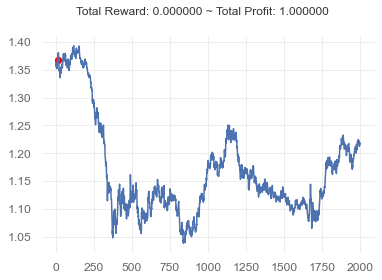

               Open     High      Low    Close  Tick_volume  Spread       EMA  \
Date                                                                            
2013-10-03  1.35812  1.36455  1.35774  1.36215      38034.0     1.0  1.358120   
2013-10-04  1.36219  1.36315  1.35384  1.35565      34243.0     1.0  1.360175   
2013-10-07  1.35629  1.35909  1.35425  1.35766      31485.0     1.0  1.358854   
2013-10-08  1.35767  1.36070  1.35573  1.35727      31661.0     1.0  1.358549   
2013-10-09  1.35729  1.36044  1.34857  1.35232      39161.0     1.0  1.358287   
...             ...      ...      ...      ...          ...     ...       ...   
2021-06-07  1.21625  1.22027  1.21456  1.21886      39910.0     7.0  1.204409   
2021-06-08  1.21910  1.21951  1.21649  1.21692      46845.0     7.0  1.204700   
2021-06-09  1.21712  1.22190  1.21712  1.21751      37724.0     7.0  1.204946   
2021-06-10  1.21770  1.21953  1.21437  1.21731      59859.0     7.0  1.205198   
2021-06-11  1.21732  1.21938

In [10]:
# build the gym environment
window_size = 12
start_index = window_size
end_index = len(df)
env = MyCustomEnv(df = df,
               window_size = start_index,
               frame_bound = (start_index, end_index), #Max 6225 Rows of data
               unit_side = 'right')

# get information from the environment
print()
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())
print("\n")
print("> possible action:", env.action_space)
print("> observation space:", env.observation_space)
print("\n")
print("> signal features: ", env.signal_features)

env.reset() # Uncomment if you need it.
env.render()

print(env.df)
print("\n")
env.df.info()

info: {'total_reward': 2888.1000000000827, 'total_profit': 0.9348112933468699, 'position': 1}


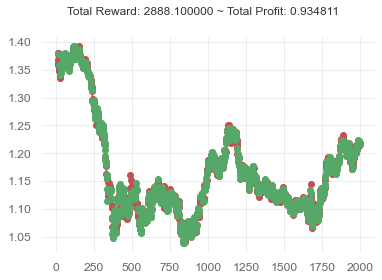

Date
2013-10-23    0.000000
2013-10-24    0.000000
2013-10-25    0.001503
2013-10-28    0.000000
2013-10-29    0.000000
                ...   
2021-06-07    0.000000
2021-06-08    0.002097
2021-06-09    0.000000
2021-06-10    0.000000
2021-06-11   -0.000082
Length: 1986, dtype: float64 



                           Strategy
-------------------------  ----------
Start Period               2013-10-23
End Period                 2021-06-11
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -6.52%
CAGR%                      -0.88%

Sharpe                     -0.13
Sortino                    -0.18
Sortino/√2                 -0.13

Max Drawdown               -22.5%
Longest DD Days            2585
Volatility (ann.)          5.42%
Calmar                     -0.04
Skew                       -0.68
Kurtosis                   23.79

Expected Daily %           -0.0%
Expected Monthly %         -0.07%
Expected Yearly %          -0.75%
Kelly Criterion            -2.54%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.56%
Expected Shortfall (cVaR)  -0.56%

Gain/Pain Ratio            -0.05
Gain/Pain (1M)             -0.1

Payoff Ratio               0.88
Profit Factor              0.95
Common Sense Ratio         0.87
CPC Index         

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2014-05-14,2020-03-20,2021-06-11,2585,-22.504506,-22.201696
2,2013-12-20,2014-01-09,2014-02-14,56,-1.431887,-1.412439
3,2013-11-04,2013-11-22,2013-12-13,39,-1.175268,-1.171110
4,2014-04-08,2014-04-08,2014-05-01,23,-0.626406,-0.305418


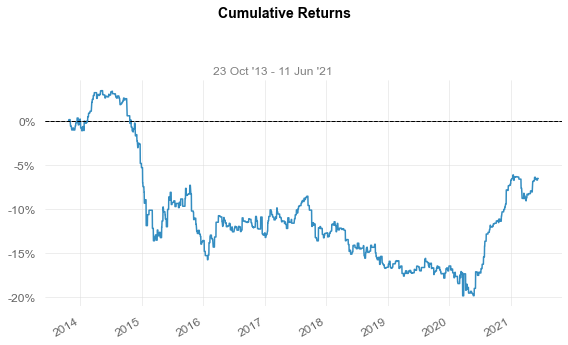

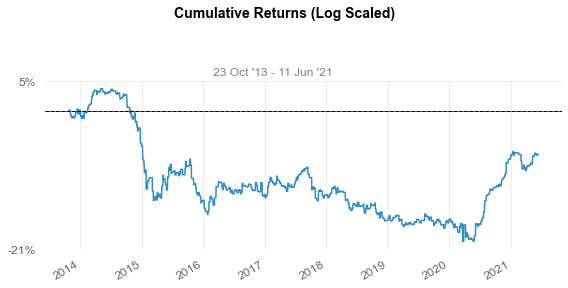

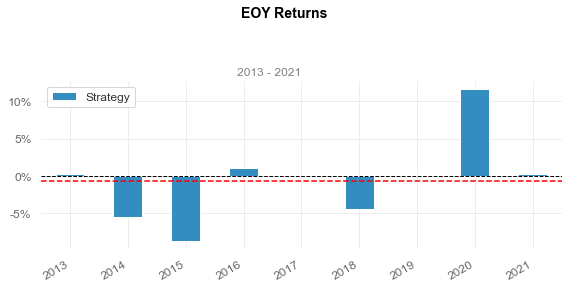

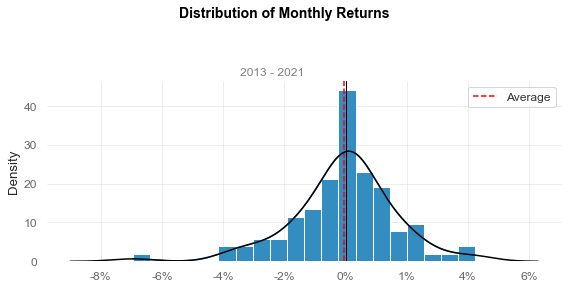

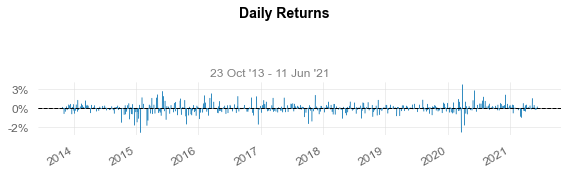

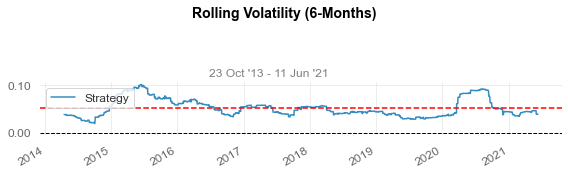

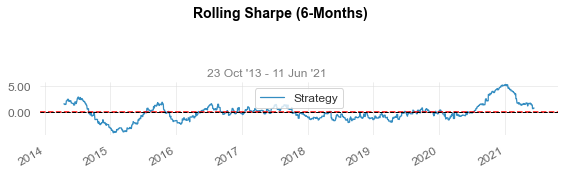

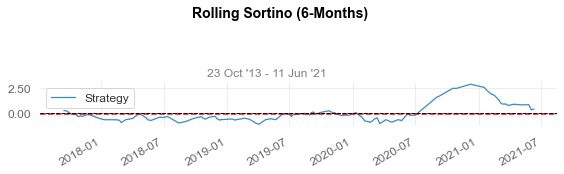

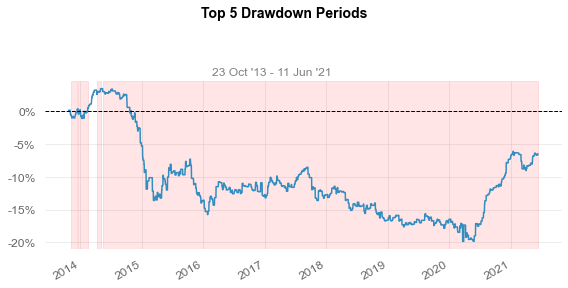

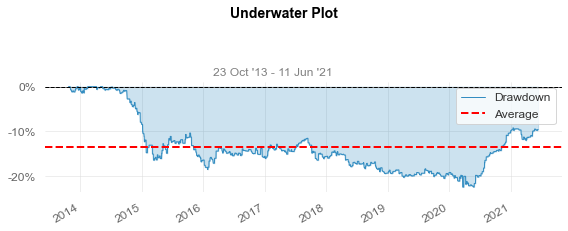

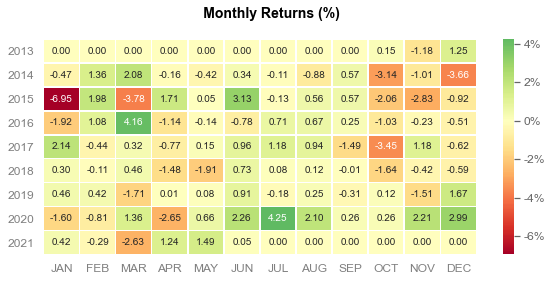

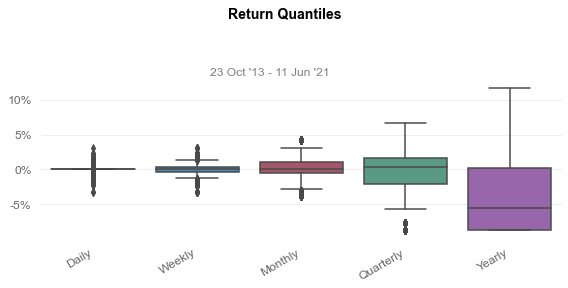

In [11]:
# make a prediction based on random actions

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()

# create a quantstats result for a comparison
qs.extend_pandas()
net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns,'\n')

qs.reports.full(returns)
qs.reports.html(returns, output='./Random Result/random quantstats.html'.format(Symbol, Timeframe))

In [12]:
env_maker = lambda: env
env = DummyVecEnv([env_maker])

In [13]:
timesteps = 50000

eval_callback = EvalCallback(
    env,
    best_model_save_path='./Saved_Model/{}-{}-Model_{}'.format(Symbol, Timeframe, timesteps),
    log_path='./logs/{}_{}'.format(Symbol, Timeframe),
    eval_freq=100,
    deterministic=True,
    render=False,
    )

policy_kwargs = dict(net_arch=[32, 32, 'lstm'])

model = A2C(
    'MlpLstmPolicy',
    env,
    gamma=0.95,
    learning_rate=0.002,
    verbose=1,
    policy_kwargs=policy_kwargs,
    ) 

model.learn(
    total_timesteps=timesteps,
    callback=eval_callback,
    )

.00
Eval num_timesteps=43300, episode_reward=2489.90 +/- 0.00
Episode length: 1987.00 +/- 0.00
Eval num_timesteps=43400, episode_reward=2489.90 +/- 0.00
Episode length: 1987.00 +/- 0.00
Eval num_timesteps=43500, episode_reward=2393.70 +/- 0.00
Episode length: 1987.00 +/- 0.00
---------------------------------
| explained_variance | -0.0568  |
| fps                | 13       |
| nupdates           | 8700     |
| policy_entropy     | 1.8e-10  |
| total_timesteps    | 43500    |
| value_loss         | 0.00627  |
---------------------------------
Eval num_timesteps=43600, episode_reward=2489.90 +/- 0.00
Episode length: 1987.00 +/- 0.00
Eval num_timesteps=43700, episode_reward=2489.90 +/- 0.00
Episode length: 1987.00 +/- 0.00
Eval num_timesteps=43800, episode_reward=2489.90 +/- 0.00
Episode length: 1987.00 +/- 0.00
Eval num_timesteps=43900, episode_reward=2393.70 +/- 0.00
Episode length: 1987.00 +/- 0.00
Eval num_timesteps=44000, episode_reward=2393.70 +/- 0.00
Episode length: 1987.00 +/- 0

In [17]:
# delete model dan loading from saved folder, comment if you didn't need it
# del model # remove model for saving and loading
## model = A2C.load('./Saved_Model/{}-{}-Model_{}/best_model.zip'.format(Symbol, Timeframe, timesteps))
model = A2C.load('D:\TugasKampus\Fun Project\MT5_TensorDL\Saved_Model\EURUSD-16408-Model_50000/best_model.zip')

env = MyCustomEnv(df = df,
               window_size = start_index,
               frame_bound = (start_index, end_index), #Max 6225 Rows of data
               unit_side = 'right')


observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    if done:
        print("info:", info)
        break

Loading a model without an environment, this model cannot be trained until it has a valid environment.
info: {'total_reward': 1191.5000000000566, 'total_profit': 0.8838780550580833, 'position': 1}


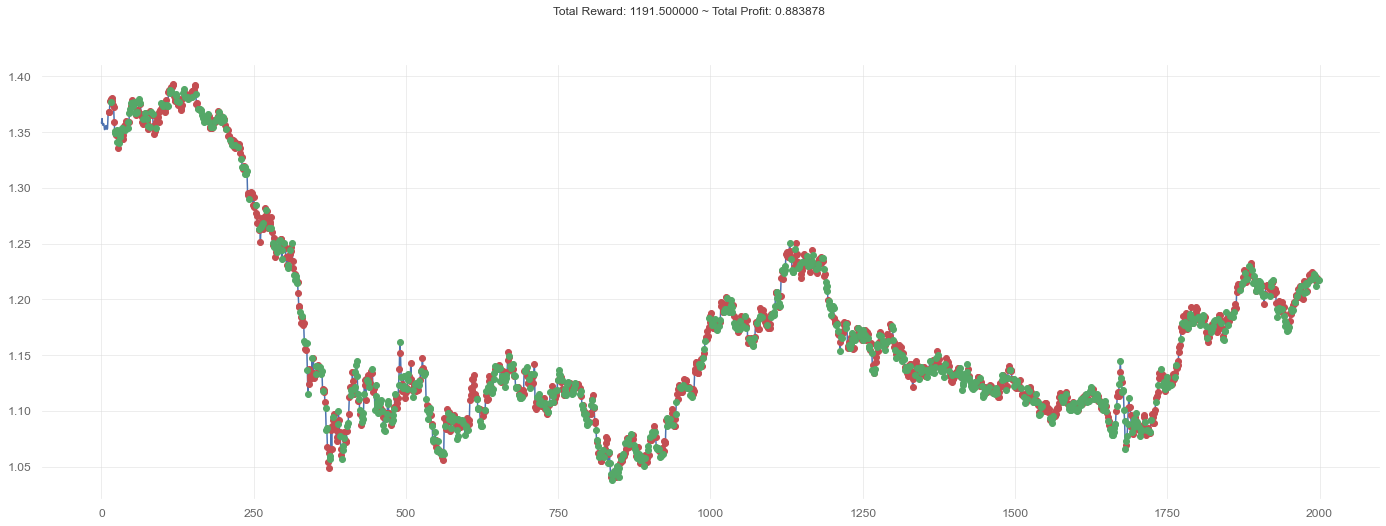

In [18]:
# gets result from trained model
plt.figure(figsize=(24, 8))
env.render_all()
plt.show()

Date
2013-10-23    0.000000
2013-10-24    0.000000
2013-10-25    0.001503
2013-10-28    0.000000
2013-10-29    0.000000
                ...   
2021-06-07   -0.004128
2021-06-08    0.000000
2021-06-09    0.000000
2021-06-10    0.000000
2021-06-11   -0.000558
Length: 1986, dtype: float64 



                           Strategy
-------------------------  ----------
Start Period               2013-10-23
End Period                 2021-06-11
Risk-Free Rate             0.0%
Time in Market             24.0%

Cumulative Return          -11.61%
CAGR%                      -1.6%

Sharpe                     -0.27
Sortino                    -0.37
Sortino/√2                 -0.26

Max Drawdown               -17.99%
Longest DD Days            2774
Volatility (ann.)          5.23%
Calmar                     -0.09
Skew                       -0.7
Kurtosis                   41.61

Expected Daily %           -0.01%
Expected Monthly %         -0.13%
Expected Yearly %          -1.36%
Kelly Criterion            -5.54%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.55%
Expected Shortfall (cVaR)  -0.55%

Gain/Pain Ratio            -0.1
Gain/Pain (1M)             -0.23

Payoff Ratio               0.92
Profit Factor              0.9
Common Sense Ratio         0.78
CPC Index         

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2013-11-06,2015-03-11,2021-06-11,2774,-17.9912,-15.975596


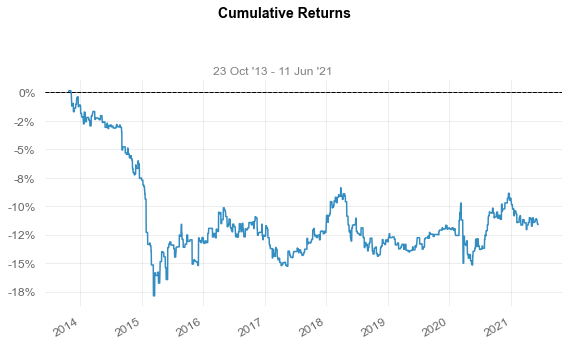

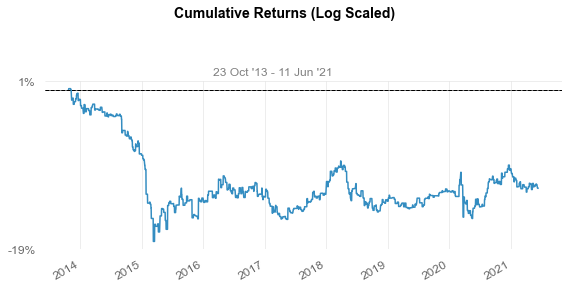

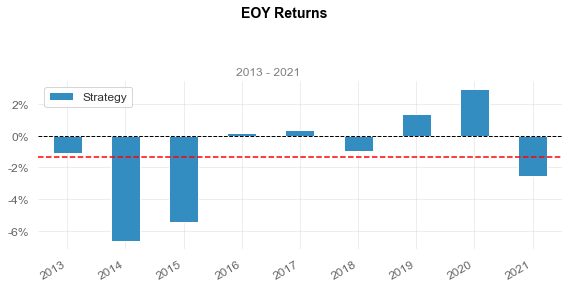

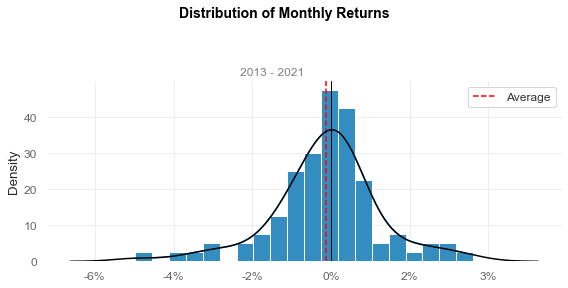

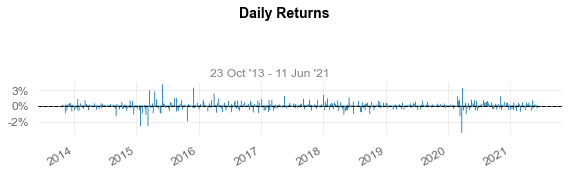

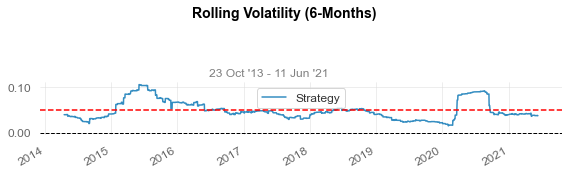

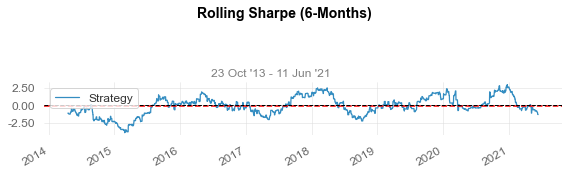

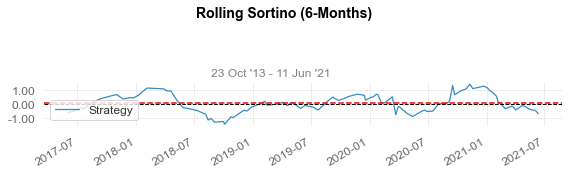

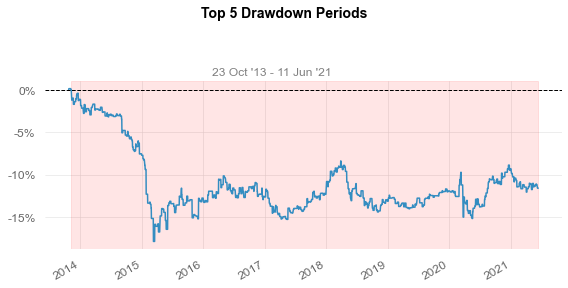

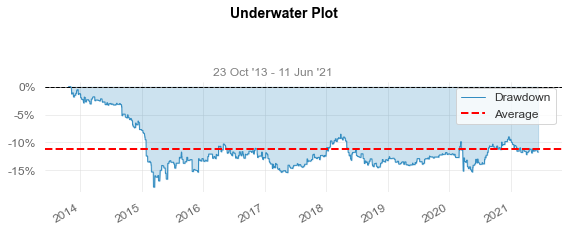

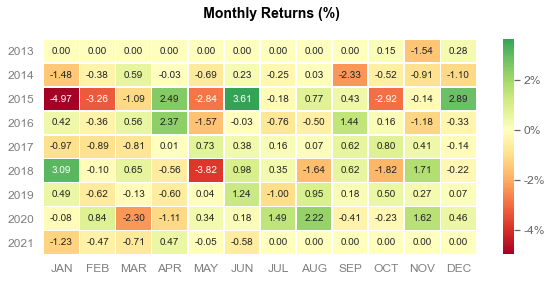

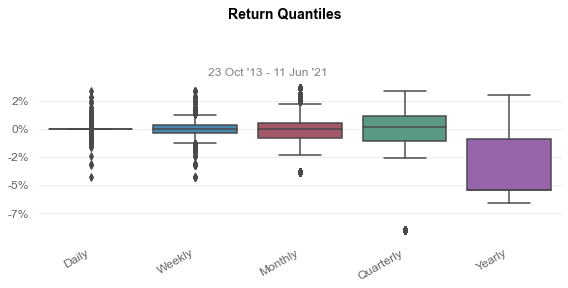

In [19]:
# gets full result from trained model
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns,'\n')

qs.reports.full(returns)
qs.reports.html(returns, output='./Backtesting/{}_{}_{}_quantstats.html'.format(Symbol, Timeframe, timesteps))